# Synthetic Objective Testing Set (SOTS) Dataset

In [1]:
# Import necessary libraries
import os
import re
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# Define constants
DATASET_ROOT_DIR = './SOTS'
BATCH_SIZE = 32

In [3]:
class SOTSDataset(Dataset):
    def __init__(self, root_dir, subset='outdoor', transform=None):
        """
        Initialize the dataset.

        Args:
            root_dir (str): Root directory of the dataset.
            subset (str): Specify 'outdoor' or 'indoor' to load respective data.
            transform (callable, optional): Transformations to apply to the images.
        """
        if subset not in ['outdoor', 'indoor']:
            raise ValueError("Subset must be 'outdoor' or 'indoor'")
        
        self.root_dir = os.path.abspath(root_dir)  # Use absolute path
        self.subset = subset
        self.transform = transform
        self.image_pairs = []
        
        # Validate directory structure
        required_subdirs = [
            os.path.join(self.root_dir, subset, 'hazy'),
            os.path.join(self.root_dir, subset, 'clear')
        ]
        for subdir in required_subdirs:
            if not os.path.exists(subdir):
                raise FileNotFoundError(f"Required directory not found: {subdir}")
        
        # Collect valid image pairs for the specified subset
        hazy_dir = os.path.join(self.root_dir, subset, 'hazy')
        clear_dir = os.path.join(self.root_dir, subset, 'clear')
        
        # File name can end with .png or .jpg
        hazy_images = sorted([f for f in os.listdir(hazy_dir) if f.lower().endswith(('.png', '.jpg'))])
        clear_images = sorted([f for f in os.listdir(clear_dir) if f.lower().endswith(('.png', '.jpg'))])

        clear_image_map = {os.path.splitext(f)[0]: f for f in clear_images}
        
        for hazy_file in hazy_images:
            match = re.match(r"(\d+)[._]", hazy_file)
            if match:
                base_name = match.group(1)
                if base_name in clear_image_map:
                    hazy_path = os.path.join(hazy_dir, hazy_file)
                    clear_path = os.path.join(clear_dir, clear_image_map[base_name])
                    self.image_pairs.append((hazy_path, clear_path))

        if not self.image_pairs:
            raise RuntimeError(f"No valid hazy-clear image pairs found for {subset}!")
        print(f"Loaded {len(self.image_pairs)} valid {subset} image pairs")

    def __len__(self):
        return len(self.image_pairs)

    def __getitem__(self, index):
        hazy_path, clear_path = self.image_pairs[index]
        
        if not os.path.exists(hazy_path):
            raise FileNotFoundError(f"Hazy image not found: {hazy_path}")
        if not os.path.exists(clear_path):
            raise FileNotFoundError(f"Clear image not found: {clear_path}")
            
        hazy_image = Image.open(hazy_path).convert('RGB')
        clear_image = Image.open(clear_path).convert('RGB')

        if self.transform:
            hazy_image = self.transform(hazy_image)
            clear_image = self.transform(clear_image)

        return hazy_image, clear_image

In [4]:
# Define image transformations
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

In [5]:
# Initialize the dataset for outdoor images
outdoor_dataset = SOTSDataset(root_dir=DATASET_ROOT_DIR, subset='outdoor', transform=image_transform)

# Initialize the dataset for indoor images
indoor_dataset = SOTSDataset(root_dir=DATASET_ROOT_DIR, subset='indoor', transform=image_transform)

Loaded 500 valid outdoor image pairs
Loaded 500 valid indoor image pairs


In [6]:
# Combine outdoor and indoor datasets
full_dataset = torch.utils.data.ConcatDataset([outdoor_dataset, indoor_dataset])

# Display the total number of samples in the full dataset
print(f"Total samples in full dataset: {len(full_dataset)}")

# Split the dataset into training and testing sets
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Display dataset split information
print(f"\nDataset split:")
print(f"- Training samples: {len(train_dataset)}")
print(f"- Test samples: {len(test_dataset)}")

Total samples in full dataset: 1000

Dataset split:
- Training samples: 800
- Test samples: 200


In [7]:
# Create data loaders for training and testing
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,  # Shuffle directly in DataLoader
    num_workers=0,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)

In [8]:
# Function to display sample images in a grid
def display_sample_images(dataset, num_samples=5):
    sample_indices = np.random.choice(len(dataset), num_samples, replace=False)
    fig, axes = plt.subplots(num_samples, 2, figsize=(10, 2 * num_samples))
    
    for i, index in enumerate(sample_indices):
        hazy_image, clear_image = dataset[index]
        hazy_image = hazy_image.permute(1, 2, 0).numpy()
        clear_image = clear_image.permute(1, 2, 0).numpy()
        
        axes[i, 0].imshow(hazy_image)
        axes[i, 0].set_title('Hazy Image')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(clear_image)
        axes[i, 1].set_title('Clear Image')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

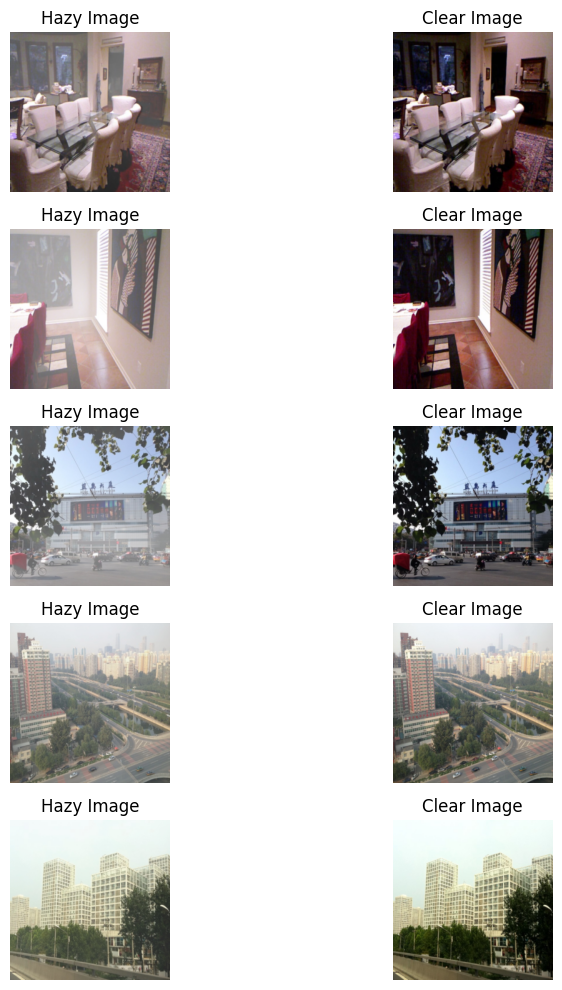

In [9]:
# Display sample images from the training dataset
display_sample_images(train_dataset, num_samples=5)